---
title: "`Autogluon`과 시계열 자료 분석 : 합리적 정보"
author: "강신성"
date: "2023-12-10"
categories: [autogluon]
---




> 과거 관측치 이외의 요인을 포함한 시계열자료를 분석해보자.

## 1. 라이브러리 imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
#---#}
from autogluon.tabular import TabularPredictor  ## 테뷸러데이터도 따로 적합?
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.common import space
#---#
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터

ref : [kaggle competition](https://www.kaggle.com/competitions/bike-sharing-demand)

In [5]:
!kaggle competitions download -c bike-sharing-demand

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip bike-sharing-demand.zip -d data

Archive:  bike-sharing-demand.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [7]:
sampleSubmission = pd.read_csv('data/sampleSubmission.csv')
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [8]:
!rm -rf data
!rm bike-sharing-demand.zip

`-` 자료 관찰

In [9]:
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [11]:
set(df_train.columns) - set(df_test.columns)

{'casual', 'count', 'registered'}

> 다른 부분이 세 개나 된다??

`-` 시계열 분석을 해야 하나?

* 시간별로 정리된 시계열 자료이긴 하다.

In [16]:
display('train', df_train.iloc[::24][:20], 'test', df_test.iloc[:10])

'train'

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
24,2011-01-02 00:00:00,1,0,0,2,18.86,22.725,88,19.9995,4,13,17
48,2011-01-03 01:00:00,1,0,1,1,8.20,8.335,44,27.9993,0,2,2
72,2011-01-04 04:00:00,1,0,1,1,5.74,9.090,63,6.0032,0,2,2
96,2011-01-05 05:00:00,1,0,1,1,9.02,11.365,47,11.0014,0,3,3
120,2011-01-06 06:00:00,1,0,1,2,5.74,8.335,63,7.0015,0,36,36
144,2011-01-07 07:00:00,1,0,1,1,8.20,10.605,69,8.9981,8,76,84
168,2011-01-08 07:00:00,1,0,0,2,6.56,9.090,74,7.0015,1,8,9
192,2011-01-09 07:00:00,1,0,0,1,3.28,4.545,53,12.9980,1,5,6
216,2011-01-10 07:00:00,1,0,1,1,4.92,6.060,50,15.0013,2,75,77


'test'

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013


> `df_train`의 형태를 볼 때, 비어있는 시간이 있는 것을 알 수 있다. 즉, 테스트 데이터는 중간중간에서 추출되었다.(20일, 10일, 20일 10일 이런 식으로...)

`-` 데이터 분석 전략

* 오히려 시계열을 피쳐엔지니어링하여 회귀문제로 바꾸는 게 적절하다.
* 시계열 -> 요일, 시간의 피쳐 추출 + **외부자료**를 활용하여 휴일 유무 체크 + **외부자료**를 활용하여 해당 요일의 날씨 체크 -> 회귀문제로 해석!

## 3. 적합

### **A. 적합**
---




In [17]:
set(df_train.columns) - set(df_test.columns)

{'casual', 'count', 'registered'}

> 예측해야할 변수는 `count`에 해당함

`-` 데이터 전처리 : step 1

In [19]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()

df_train_featured = df_train_featured.drop(['casual', 'registered'], axis = 1)  ## 그냥 드롭해버림

`-` `predictor` 생성 및 적합, 예측

In [20]:
## step 2
predictr = TabularPredictor(label = 'count')

## step 3
predictr.fit(df_train_featured)

## step 4
yhat = predictr.predict(df_train_featured)
yyhat = predictr.predict(df_test_featured)

No path specified. Models will be saved in: "AutogluonModels/ag-20231210_083647"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231210_083647"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #140-Ubuntu SMP Thu Aug 4 02:23:37 UTC 2022
CPU Count

[1000]	valid_set's rmse: 136.065


	-135.958	 = Validation score   (-root_mean_squared_error)
	7.72s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM ...
	-134.0804	 = Validation score   (-root_mean_squared_error)
	4.98s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-122.0128	 = Validation score   (-root_mean_squared_error)
	0.7s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-134.2362	 = Validation score   (-root_mean_squared_error)
	6.66s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-128.4294	 = Validation score   (-root_mean_squared_error)
	0.53s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-136.5314	 = Validation score   (-root_mean_squared_error)
	24.97s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-135.0751	 = Validation score   (-root_mean_squared_error)
	1.07s	 = Training   runtime
	0.01s	 = Validatio

`-` 적합한 것을 관찰해보자.

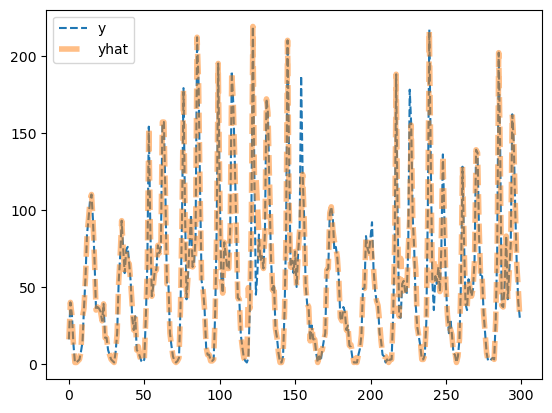

In [25]:
plt.plot(df_train['count'][:300], '--', label = 'y')
plt.plot(yhat[:300], '--', label = 'yhat', alpha = 0.5, lw = 4)
plt.legend()

> 거의 동일하다. 이상하리만치 적합이 잘 되어있다. (왜 이렇게 잘맞춤???)

### **B. 제출**
---




In [27]:
submission = sampleSubmission.copy()
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [28]:
submission['count'] = yyhat

In [29]:
submission.to_csv('submission.csv', index = False)
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "autogloun tabular predict"
!rm submission.csv

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 88.4kB/s]
Successfully submitted to Bike Sharing Demand

`-` 순위 확인...

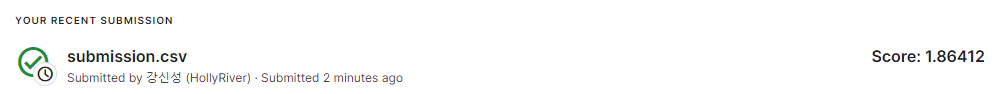

> 상당히 충격적인 결과, 냈다면 3171/3242등임...

`-` yyhat을 살펴보면...

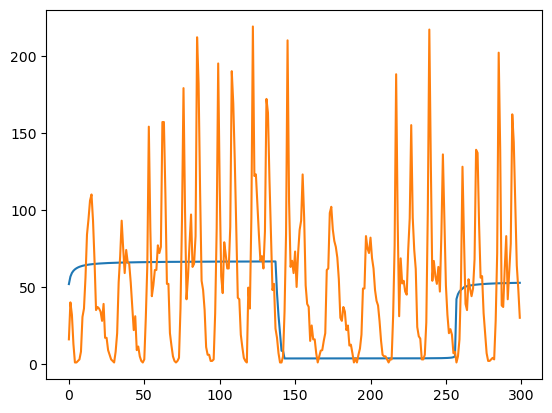

In [34]:
plt.plot(yyhat[:300])
plt.plot(yhat[:300])

> `yhat`이랑 근본적으로 모양 자체가 다름...(요일이나 뭐 그런거나 다 신경쓰지 않고 뭉툭하게 적합하였음.)

## 4. 적합 2

불필요한 변수가 있거나, 공선성이 있거나, y와 완전히 관련된 변수가 따로 있나?

### **A. 피쳐 엔지니어링**
---




`-` 일단 시계열로 적합할 생각이 없으므로, `datetime` 열은 삭제하는 게 좋겠음(인덱스 역할만 하는 쓸모없는 변수임)

In [38]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)  ## 추가적으로 'datetime' 열을 제거하였음.
df_test_featured = df_test_featured.drop(['datetime'],axis=1)

### **B. 적합**
---




`-` 동일하게 적합...

In [40]:
## step 2
predictr = TabularPredictor(label = 'count')

## step 3
predictr.fit(df_train_featured, verbosity = False)  ## 적합 과정을 말 많이 하지 말라고 하는 거

## step 4
yhat = predictr.predict(df_train_featured)
yyhat = predictr.predict(df_test_featured)

No path specified. Models will be saved in: "AutogluonModels/ag-20231210_085447"


`-` 적합결과 시각화

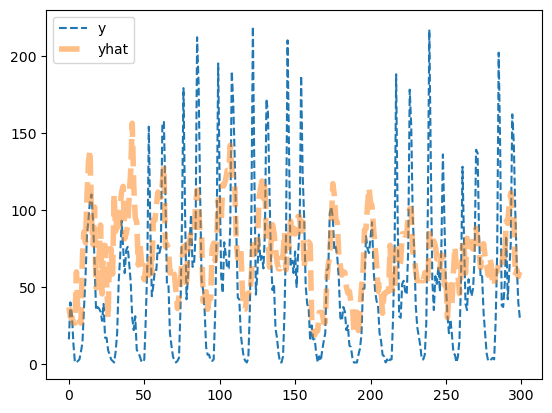

In [42]:
plt.plot(df_train['count'][:300], '--', label = 'y')
plt.plot(yhat[:300], '--', label = 'yhat', alpha = 0.5, lw = 4)
plt.legend()

> 너무 잘 적합되는 것을 벗어났다.(오히려 좋아.)

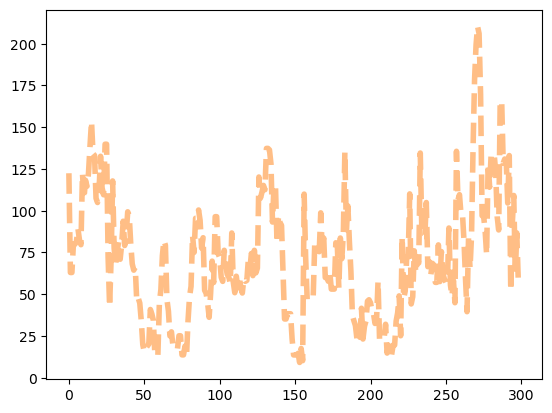

In [44]:
plt.plot(yyhat[:300], '--', alpha = 0.5, lw = 4, color = 'C1')

`-` 더 깔끔하고 예쁜 시각화(`seaborn`)

In [63]:
df = pd.concat([df_train, df_test]).assign(datetime = lambda _df : _df.datetime.apply(pd.to_datetime))\
.assign(count_hat = yhat.tolist() + yyhat.tolist(), dataset_type = ['train']*len(yhat) + ['test']*len(yyhat))

> `test`와 `train`을 따로 시각화해버리면 시간이 연속되지 않아 이상함.

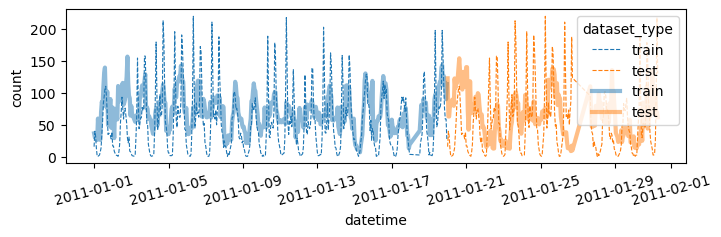

In [88]:
sns.lineplot(
    df.sort_values('datetime')[:(24*28)], ## 28일에 해당하는 자료만 시각화
    x = 'datetime', y = 'count',
    hue = 'dataset_type', linestyle = '--',
    lw = 0.8
)

sns.lineplot(
    df.sort_values('datetime')[:(24*28)],
    x = 'datetime', y = 'count_hat',
    hue = 'dataset_type',
    lw = 3, alpha = 0.5
)

fig = plt.gcf()
fig.set_size_inches(8,2)  ## 사이즈 조절
plt.xticks(rotation = 15);  ## x축 눈금 회전시키기

> 왜 `test` 데이터의 실제 관측치가 보이는 지는 모르겠지만(`matplotlib`에서는 결측치를 표기하지 않았었음...) 전보다는 나아보임.

`-` 상기 과정을 많이 사용할 것 같으니 함수로 구현

In [105]:
def plotting(yhat, yyhat) :
    df = pd.concat([df_train, df_test]).assign(datetime = lambda _df : _df.datetime.apply(pd.to_datetime))\
.assign(count_hat = yhat.tolist() + yyhat.tolist(), dataset_type = ['train']*len(yhat) + ['test']*len(yyhat))
    sns.lineplot(
        df.sort_values('datetime')[:(24*28)], ## 28일에 해당하는 자료만 시각화
        x = 'datetime', y = 'count',
        hue = 'dataset_type', linestyle = '--',
        lw = 0.8
    )
    
    sns.lineplot(
        df.sort_values('datetime')[:(24*28)],
        x = 'datetime', y = 'count_hat',
        hue = 'dataset_type',
        lw = 3, alpha = 0.5
    )
    
    fig = plt.gcf()
    fig.set_size_inches(8,2)  ## 사이즈 조절
    plt.xticks(rotation = 15);  ## x축 눈금 회전시키기
    fig.show()

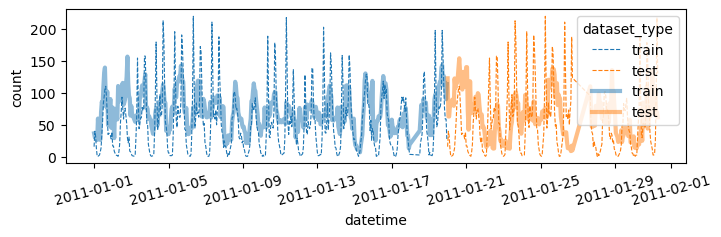

In [107]:
plotting(yhat, yyhat)

### **C. 제출**
---




`-` 제출도 자동화...

In [108]:
submission['count'] == yyhat
submission.to_csv('submission.csv', index = False)
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"
!rm submission.csv

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 103kB/s]
Successfully submitted to Bike Sharing Demand